## 导入相关包

In [1]:
import requests
import json
import re
from bs4 import BeautifulSoup
import time
import pymongo
import json
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd

## 规则系数

In [2]:
#------- 不同平台属性的对应关系 ------#
elements_mapping = {
    '型号':'产品型号',
    '制冷功率（W）':'制冷功率(W)',
    '制冷功率':'制冷功率(W)',
    '制热量（W）':'制热量(W)',
    '制热功率（W）':'制热功率(W)',
    '制热功率':'制热功率(W)',
    '电辅加热功率（W）':'电辅加热功率(W)',
    '电辅加热':'电辅加热功率(W)',
    '匹数':'产品匹数',
    '制冷量（W）':'制冷量(W)',
    '室内机尺寸(宽x高x深)mm':'内机尺寸（宽x高x深）mm',
    '内机机身尺寸(宽x高x深)mm':'内机尺寸（宽x高x深）mm',
    '室外机尺寸(宽x高x深)mm':'外机尺寸（宽x高x深）mm',
    '外机机身尺寸(宽x高x深)mm':'外机尺寸（宽x高x深）mm',
    '变频/定频':'定频/变频',
    '适用面积':'适用面积（平方米）',
    '能效比':'能源消耗效率',
    '定频机能效比':'能源消耗效率',
    '变频机能效比':'能源消耗效率',
    '内机噪音 dB(A)':'内机噪音dB（A）',
    '内机噪音(dB(A)':'内机噪音dB（A）',
    '外机噪音 dB(A)':'外机噪音dB（A）',
    '外机噪音(dB(A)':'外机噪音dB（A）',
    '循环风量m³/h':'循环风量(m³/h)',
    '循环风量（m³/h）':'循环风量(m³/h)',
    '循环风量(m3/h)':'循环风量(m³/h)',
    '额定电压/频率（V/Hz）':'电压/频率（V/Hz）',
    '电压/频率':'电压/频率（V/Hz）'
}
#------- 不同平台属性的对应关系 ------#


#--------- 参数量化关系 --------------#
zlj_role = {'R32':1, 'R41a':0.75, '新冷媒（R410a）':0.75, 'R22':0.5} # 制冷剂 
lxdj_role = {'新一级能效':1,'一级能效':0.75,'二级能效':0.5,'三级能效':0.25} # 能效等级
ps_role = {'5匹':1,'4匹':0.9,'大3匹':0.8,'3匹':0.7,'2.5匹':0.6,'2匹':0.5,'1.5匹':0.4,'正1.5匹':0.4,'小1.5匹':0.3,'大1匹':0.2,'1匹':0.1,'小1匹':0.0} # 匹数
bpdp_role = {'变频':1,'定频':0.5} # 变频定频 
#--------- 参数量化关系 ---------------#


#--------- 综合指数 --------------#
xishu = {"价格":2,"制热功率":1,"制冷功率":1,"能效等级":1,"制冷剂":1,"产品匹数":1,"变频/定频":1}
#--------- 综合指数 --------------#


#--------- 启动 mongodb 服务 ---------#
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
# mydb = myclient["jdtest"]
mydb = myclient["kongtiao"]
mycol = mydb["sites06012"]
#--------- 启动 mongodb 服务 ---------#

#--------- 获取页数 ------------#
begin_index = 1
end_index = 150
#--------- 获取页数 ------------#



## 定义不同的方法

In [3]:
'''
    获取商品详细 元素
'''

def delete_tips(element): 
    result = re.search('<dd class="Ptable-tips">.*?</dd>',element,re.S)
    if result != None:
        result = result.group()
        element = re.sub(result,'',element,re.S)
    return element

'''
    获取 键和值
'''
def get_key_value(string): 
    dt = re.findall('<dt>(.*?)</dt>',string,re.S)[0]
    if dt in elements_mapping:
        dt = elements_mapping[dt]
    dd = re.findall('<dd>(.*?)</dd>',string,re.S)[0]
    return (dt,dd)

'''
    去除 换行符和空格
'''
def delete_enter_blank(string): 
    return string.replace('\n','').replace('（','(').replace('）',')').strip()

'''
    获取产品简介元素（价格、优惠券、名字、地址）
'''
def get_good_des(dict_tmp,good): 
    try:
        dict_tmp['价格'] = float(str(good.select('div.p-price > strong > i')[0]).replace('<i>','').replace('</i>',''))
        dict_tmp['优惠券'] = re.findall('">(.*?)<',str(good.select('div.p-icons > i.goods-icons4')))
        
        pattens_name = 'p-name p-name-type-3.*?<em>(.*?)</em'
        name = re.findall(pattens_name,str(good),re.S)
        dict_tmp['名字'] = delete_enter_blank(name[0])
        
        pattens_goods = 'p-name p-name-type-3.*?href="(.*?)"'
        goods_url = re.findall(pattens_goods,str(good),re.S)
        dict_tmp['地址'] = 'https:'+goods_url[0]
        
    except:
        print("获取商品简介出错！")
        
'''
    获取商品详情元素
'''
def get_good_details(dict_tmp, html_good): 
    pattens_elements = '<dl class="clearfix" style="margin:0">(.*?)</dl>'
    elements = re.findall(pattens_elements,html_good,re.S)
    for i in elements:
        i = delete_tips(i)
        tmp_element = get_key_value(i)    
        dict_tmp[tmp_element[0]] = tmp_element[1]
        
'''
    访问产品详细界
'''
def get_good(url): 
    url_head = {
        'user-agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',
        'cookie':'__jdu=1602134970203511970437; shshshfpa=0da4f7a3-3a60-9c8d-f8f7-df47db76dae2-1602134971; shshshfpb=fIObUtHfu4nnmUVscJm7OrA%3D%3D; PCSYHWHR=1; PCSYCityID=CN_710000_710400_710441; user-key=4071e7c9-2c98-439c-95bd-ceb59b58e0e0; cn=0; unpl=V2_ZzNtbUpWQUIiW09VeU4LDGIAFlsRBBFAdwxHAHhKXVI3AxoKclRCFnUUR1ZnGFgUZgoZWUBcQhNFCEdkeBBVAWMDE1VGZxBFLV0CFSNGF1wjU00zQwBBQHcJFF0uSgwDYgcaDhFTQEJ2XBVQL0oMDDdRFAhyZ0AVRQhHZHseXQZnARdVRFZAFHcMRlRzH10AZQUibUVncyVwCk5QeR9sBFcCIh8WC0sWdgFFVzYZWwRkAxBYSlFCFnQKQlR7EVoEYgEUbUNnQA%3d%3d; __jdv=76161171|baidu-pinzhuan|t_288551095_baidupinzhuan|cpc|0f3d30c8dba7459bb52f2eb5eba8ac7d_0_903ffb803ff84257bbcd350e2b0fa19f|1614905576946; _fbp=fb.1.1614991002104.733794731; mt_xid=V2_52007VwMVU15YUF8XTxhfBGUHElJVXlNfHU8pWAA1ARtQVQpOXhxNGUAANwEbTlRaW10DHk0LBWIFEVJbC1ZeL0oYXwV7AhBOXF9DWh9CG10OZwoiUG1YYlgdQR9dBGYBF1RtWFReGw%3D%3D; areaId=19; RT="z=1&dm=jd.com&si=2ymdauyynxi&ss=klxefjpu&sl=1&tt=11r&ld=120&ul=45t&hd=45y"; __jda=122270672.1602134970203511970437.1602134970.1615001356.1615012081.19; __jdc=122270672; _pst=%E8%BF%98%E8%A6%81%E6%83%B3%E5%90%8D%E5%AD%97%E5%93%92; logintype=qq; unick=%E8%BF%98%E8%A6%81%E6%83%B3%E5%90%8D%E5%AD%97%E5%93%92; pin=%E8%BF%98%E8%A6%81%E6%83%B3%E5%90%8D%E5%AD%97%E5%93%92; npin=%E8%BF%98%E8%A6%81%E6%83%B3%E5%90%8D%E5%AD%97%E5%93%92; _tp=yONLlsWra6smLxKduIIRXs801Ib%2FBwoC2s1eYrsApgBwm%2B53NpZWF%2F2%2BqMP8nMzlspd2yRV2XuCh%0D%0ADbeYjHyumQ%3D%3D; pinId=OQvCsSEqFvkQkkG87lOYZ-HJv2tpInbo; ipLoc-djd=19-1607-6737-53586; wlfstk_smdl=dknosqauvnbncf75f2jygz3kavlwnvy1; thor=DEB88672C3A02148C3DB441AF2919E1F4857C47980F3AC533A8C06FC4B6EC571C435B50EC97926A1DA51DB560BB6E49FA8B80EA03768BF354562D830A9975C2D6C9B483A8D68E338BE063CF292DA2A539D5A7FD5A77FCDB639DF9B5DFE48D7A6ECC441997D3386C0343219F34FB67E3C9B7186462EA495353748A376B877E39B; __jdb=122270672.95.1602134970203511970437|19.1615012081; shshshfp=19e3f6d4db0954544943861442fd5145; shshshsID=092d9397370e78e26f1d3d2b40a457c8_59_1615017596221; 3AB9D23F7A4B3C9B=UWLJ7JPYCOZWVZ5HORVXMMXCV3XHR7WENIRVABF5LOIJ627RH5AP7FG6MHGZ2WMWKKTMAPPBJHRQFNVAXUTYHQ6OJQ'
    }
    request_data = requests.get(url,headers = url_head)
    return request_data.text

'''
    更新综合系数
    传入 查询后的res迭代器 和 系数规则
'''
def update_zh(res, xishu): # 
    index = 0
    for x in res:
        tmp_zr = 0
        tmp_zl = 0
        tmp_zh = 0.0
        tmp_price = (10000 - x["价格"])/10000
        tmp_zh = tmp_zh + xishu["价格"]*tmp_price
        try:

            tmp_zr = int(re.findall('(\d+)',x["制热功率(W)"])[0])
            tmp_zl = int(re.findall('(\d+)',x["制冷功率(W)"])[0])

        except:
            pass

        if "能效等级" in x:
            tmp_zh = tmp_zh + get(x["能效等级"],ps_role,xishu["能效等级"])
        if "制冷剂" in x:
            tmp_zh = tmp_zh + get(x["制冷剂"],bpdp_role,xishu["制冷剂"])
        if "产品匹数" in x:    
            tmp_zh = tmp_zh + get(x["产品匹数"],ps_role,xishu["产品匹数"])
        if "变频/定频" in x:
            tmp_zh = tmp_zh + get(x["变频/定频"],bpdp_role,xishu["变频/定频"])
            
        tmp_zh = tmp_zh + xishu["制热功率"]*0.00014*tmp_zr +xishu["制冷功率"]*0.00014*tmp_zl

        mycol.update_one(x,{"$set":{"综合系数":tmp_zh }})
#         print(x)
        index = index + 1

"""
    获取参数换算结果
"""
def get(data,role,alpha):
    tmp = 0.0
    if data in role:
        tmp = role[data] * alpha
    return tmp

"""
    数据库更新
"""
def upsert(mycol,data):
    if '地址' in data:
        mycol.update_one(
            {'地址':data['地址']},
            {'$set':data},
            upsert=True
        )
    else:
        print("更新数据错误！")
        
"""
    打印数据表
"""
def drawpandas(res):
    index = 0
    key_dict = {"综合系数":[],"地址":[],"价格":[],"制冷剂":[],"制冷功率(W)":[],"制热功率(W)":[],"能效等级":[],"产品匹数":[],"变频/定频":[]}
    res_tmp =[]
    for x in res:
        print((x))
        index = index + 1

        check = 0

    #     for i in key_dict:
    #         if i in x:
    #             check = check + 1

    #     if check < len(key_dict):
    #         continue
        for i in key_dict:
            if (i in x) == False:
                x[i] = 'None'
            key_dict[i].append(x[i])
        res_tmp.append(x)
    # # print(key_dict)
    # print (sorted(res_tmp, key = lambda i: (i['综合系数'], i['价格'])) )
    return pd.DataFrame(key_dict)



## 数据获取模块

In [4]:
url_head = {
    'user-agent':'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36',
    'cookie':'__jdu=1602134970203511970437; shshshfpa=0da4f7a3-3a60-9c8d-f8f7-df47db76dae2-1602134971; shshshfpb=fIObUtHfu4nnmUVscJm7OrA==; pinId=R_tN_Pl-SiBKGGAfXz3hxQ; unpl=V2_ZzNtbRUASkYgXU9SKRFdBWIFFg4SUBYddQBAVX0RXFJiAxRfclRCFnUUR1BnGlwUZgsZXEBcQRNFCEdkeBBVAWMDE1VGZxBFLV0CFSNGF1wjU00zQwBBQHcJFF0uSgwDYgcaDhFTQEJ2XBVQL0oMDDdRFAhyZ0AVRQhHZHseXQZnARdVRFZAFHcMRlRzH10AZQUibUVncyV3CkFcfRpsBFcCIh8WC0ocdApFUzYZWwRkAxBYSlFCFnQKQlR7EVoEYgEUbUNnQA==; user-key=2c6672b4-fef8-4b88-9bcc-d7440531a118; areaId=18; ipLoc-djd=18-1522-3619-31371; mt_xid=V2_52007VwMVU15YUF8XTxhfBGUHElJVXlNfHU8pDlYyUEAHX1hOWBseHUAANwYWTg1dUQgDShhUAmEGEVcOWVpYL0oYXwV7AhVOXFpDWhlCGlkOZwEiUm1YYlIeQRxdBWULE1RfWFBaHUgbVAxXARZTXw==; shshshfp=1117bc7f9a72985b50e796970347fb9c; 3AB9D23F7A4B3C9B=UWLJ7JPYCOZWVZ5HORVXMMXCV3XHR7WENIRVABF5LOIJ627RH5AP7FG6MHGZ2WMWKKTMAPPBJHRQFNVAXUTYHQ6OJQ; __jda=122270672.1602134970203511970437.1602134970.1622712232.1623287696.49; __jdv=122270672|localhost:8888|-|referral|-|1623287696082; __jdc=122270672; shshshsID=7327279d88b074d440746b9db9e27b01_2_1623287734059; __jdb=122270672.2.1602134970203511970437|49.1623287696',
    'cache-control':'max-age=0'
}

for i in range(begin_index,end_index):
    request_data = requests.get('https://list.jd.com/list.html?cat=737%2C794%2C870&psort=3&ev=exbrand_%E6%A0%BC%E5%8A%9B%EF%BC%88GREE%EF%BC%89%5E&psort=3&page='+str(i)+'&s='+str(i*30+1)+'&click=1',headers = url_head)
#     print(request_data.text)
    html_list = request_data.text
    soup = BeautifulSoup(html_list,'lxml')
    goods = soup.select('#J_goodsList > ul > li >div')
    x = 0
    print('完成',((i-begin_index)/(end_index-begin_index))*100,'%')
    for good in goods:
        try:
            dict_tmp = {} # 初始化数据容器
            get_good_des(dict_tmp, good) #获取产品简介

            print(x,dict_tmp['地址'])

            x = x + 1

            if dict_tmp['地址'][8] != 'i':
                continue

            html_good = get_good(dict_tmp['地址']) # 访问该商品地址
#             print(len(html_good))

            get_good_details(dict_tmp, html_good) # 获取产品详细

    #         y = mycol.insert_one(dict_tmp)

            upsert(mycol,dict_tmp)

    #         time.sleep(1)

    #         print(len(dict_tmp),y.inserted_id)
        except:
            print('第',i,'页获取出现错误！')

print("数据更新完毕")
        
    

完成 0.0 %
0 https://item.jd.com/100019386660.html
1 https://item.jd.com/100010607429.html
2 https://item.jd.com/100019386658.html
3 https://item.jd.com/100015491508.html
4 https://item.jd.com/100017981386.html
5 https://item.jd.com/100009296773.html
6 https:https://ccc-x.jd.com/dsp/nc?ext=aHR0cHM6Ly9pdGVtLmpkLmNvbS8xMDAwMDg3MTg1MDkuaHRtbA&amp;log=ohNTx9Vf8rQ4pKOrKtyDL_uLmQqQFDD8NR3U2hoKhg1gRFGTCW6yqURfjpEqwpDinj2xQQesLrYth8Rq7JWzkekEOcbkhWWq2jPFB0R30Pwgt-jZSI3YcUJfqmTZNiXiSsCqeSLJCFnVmebv5NLtqgiSmnhdl_33RWATOke6NdU77r_18gHl9n_IqP9xPd41-2cxNuQCMiUnBpxinDXCts0nIPULVTa_ngyJqydD8LBj1UyXN24Iz6FwfgSGSYRkDZ8i6hNSnBqqRX60w1D7824J8xYajzV5cjMk_Za3HPEIKZwOcg5YwDu4UrTep9GJl2o1CKDG8q5GnjoqOAPz2t7M7E7YaEKTfQddsDTbKIBnhCgi7MWD5DEe2oY6VvbnAga4g5SvHHwMO39oSIFchTwSVhlnfH1eRbYkhpgJcbY27q6U5GMOlbB7indoRB8O6o_GLDRHiU2p3T3zv0fHoZAj-dwW9Agx6ZKbBNZg2PJqcC0rYlvjZvXOm_xyqtsZ3IFc9e48yxb2G7ty0xjt9GsJJi9sn3RVss6m4B3cZpMjVSXkaphlSgidCBQL7amtVpRGVWg5_PdR-kcEivfosQEW-bjSwCHdFUFGbQ_4eyGmtD59fX9a7Rn7uDJH6TzlF8u4pNVsMLvC

26 https://item.jd.com/100014511344.html
27 https://item.jd.com/100016364640.html
28 https://item.jd.com/100018974750.html
29 https://item.jd.com/100019272914.html
完成 1.342281879194631 %
0 https://item.jd.com/100020575594.html
1 https://item.jd.com/100016724944.html
2 https://item.jd.com/100019979376.html
3 https://item.jd.com/10027190698926.html
4 https://item.jd.com/100018974220.html
5 https://item.jd.com/100008718511.html
6 https:https://ccc-x.jd.com/dsp/nc?ext=aHR0cHM6Ly9pdGVtLmpkLmNvbS8xMDAzMTA2MTMzODgxOC5odG1s&amp;log=b5V7kC1yqXj2_Ya85qbR2p65nM9UtrOnJzb6oawXNybDUVzr7Vcd5BWRGzz1mLTUqgnqYVJRvTism6srC6li3ZXgixUDSEFk3SRWjhhG5bZ5C4cpGQXhoqYfuBIS2FGRzu9uxuwsCLIWTpIZoIxKaEYemJ8VXVPrtDz18iJy0iFZ6M04tZwM-WppBlckM00IAX-EihdafNFR0wnBkNAPZRG0IskeRJQm304_eQhR6dFwpRU_1l7hMpRSSshGCTqyJEiYPPlVZUTRb1XasAoxEPzusj8tYEF2zcNJgNVhOxLlc3QzNkyhv0hgglmTBrn8yWjsiI4fS4pSu-4hsxSJrvrP2TDGhc3GFwlNvy0EnwGpYA15ss0vFoqtYRA3E90gZwaokFojuEXS7_ftUT_eZqvc4gLD0YAMnIAVm0Z0-RmU842dy20J9IJZ-eL0xkactMmYNkk2mCCJ3kqFQmiZQ-

3 https://item.jd.com/10023764741796.html
4 https://item.jd.com/100020615886.html
5 https://item.jd.com/10023753200531.html
6 https://item.jd.com/100021176484.html
7 https://item.jd.com/56061128123.html
8 https://item.jd.com/100011438157.html
9 https://item.jd.com/10021776118288.html
10 https://item.jd.com/100011499311.html
11 https://item.jd.com/100018431936.html
12 https://item.jd.com/10026223158464.html
13 https://item.jd.com/100010548051.html
14 https://item.jd.com/10023684529451.html
15 https://item.jd.com/10025368486743.html
16 https://item.jd.com/68529095447.html
17 https://item.jd.com/38260933940.html
18 https://item.jd.com/100020359904.html
19 https://item.jd.com/10027837725569.html
20 https://item.jd.com/100019566448.html
21 https://item.jd.com/100011127213.html
22 https://item.jd.com/10021808681917.html
23 https://item.jd.com/10106871251.html
24 https://item.jd.com/10026220008941.html
25 https://item.jd.com/100019566464.html
26 https://item.jd.com/10028165865367.html
27 http

18 https://item.jd.com/10951248176.html
19 https://item.jd.com/100009443149.html
20 https://item.jd.com/10027198341142.html
21 https://item.jd.com/10031218066727.html
22 https://item.jd.com/10030124455321.html
23 https://item.jd.com/10023915578784.html
24 https://item.jd.com/10027786034235.html
25 https://item.jd.com/10026701391129.html
26 https://item.jd.com/100022287680.html
27 https://item.jd.com/100016160588.html
28 https://item.jd.com/10021842311152.html
29 https://item.jd.com/100019550816.html
完成 8.053691275167784 %
0 https://item.jd.com/10027532004524.html
1 https://item.jd.com/10027451205446.html
2 https://item.jd.com/10027532004523.html
3 https://item.jd.com/100002801800.html
4 https://item.jd.com/10029317725005.html
5 https://item.jd.com/10024802597404.html
6 https://item.jd.com/42498078984.html
7 https://item.jd.com/10024218223323.html
8 https://item.jd.com/100016465238.html
9 https://item.jd.com/100010516877.html
10 https://item.jd.com/10020506961089.html
11 https://item.jd

3 https://item.jd.com/10026185641158.html
4 https://item.jd.com/100008570078.html
5 https://item.jd.com/10021868911040.html
6 https://item.jd.com/10029317725006.html
7 https://item.jd.com/10024245849239.html
8 https://item.jd.com/100019567908.html
9 https://item.jd.com/10025282155546.html
10 https://item.jd.com/100008754585.html
11 https://item.jd.com/13643872968.html
12 https://item.jd.com/10027403522982.html
13 https://item.jd.com/3459261.html
14 https://item.jd.com/100020615896.html
15 https://item.jd.com/10024212183222.html
16 https://item.jd.com/100016414784.html
17 https://item.jd.com/100008706832.html
18 https://item.jd.com/100020359838.html
19 https://item.jd.com/10022184865780.html
20 https://item.jd.com/10026419838409.html
21 https://item.jd.com/100011756133.html
22 https://item.jd.com/100009447559.html
23 https://item.jd.com/3072578.html
24 https://item.jd.com/10025683915534.html
25 https://item.jd.com/10025040969119.html
26 https://item.jd.com/10025259063399.html
27 https:/

20 https://item.jd.com/10028459686461.html
21 https://item.jd.com/100019460168.html
22 https://item.jd.com/100009363879.html
23 https://item.jd.com/44004680777.html
24 https://item.jd.com/10027848741909.html
25 https://item.jd.com/100020615904.html
26 https://item.jd.com/100007452909.html
27 https://item.jd.com/66195526068.html
28 https://item.jd.com/66955670905.html
29 https://item.jd.com/100008643447.html
完成 16.778523489932887 %
0 https://item.jd.com/10023355279496.html
1 https://item.jd.com/10024795204278.html
2 https://item.jd.com/100020912846.html
3 https://item.jd.com/10031721442482.html
4 https://item.jd.com/100008738467.html
5 https://item.jd.com/100009525311.html
6 https://item.jd.com/100016590094.html
7 https://item.jd.com/100016583282.html
8 https://item.jd.com/100020700198.html
9 https://item.jd.com/54119495480.html
10 https://item.jd.com/61494266346.html
11 https://item.jd.com/10020204735687.html
12 https://item.jd.com/10027517254721.html
13 https://item.jd.com/10026905132

6 https://item.jd.com/100007957943.html
7 https://item.jd.com/10022870891370.html
8 https://item.jd.com/10024218223325.html
9 https://item.jd.com/10026565131912.html
10 https://item.jd.com/3071904.html
11 https://item.jd.com/100017095756.html
12 https://item.jd.com/54119495481.html
13 https://item.jd.com/56309069696.html
14 https://item.jd.com/71904744409.html
15 https://item.jd.com/10023844959286.html
16 https://item.jd.com/10023984379119.html
17 https://item.jd.com/10027523688287.html
18 https://item.jd.com/13134862122.html
19 https://item.jd.com/70912557403.html
20 https://item.jd.com/10987629512.html
21 https://item.jd.com/10026293966314.html
22 https://item.jd.com/10026210861460.html
23 https://item.jd.com/10027099646870.html
24 https://item.jd.com/66789089816.html
25 https://item.jd.com/10029444368378.html
26 https://item.jd.com/100010728291.html
27 https://item.jd.com/10028954703864.html
28 https://item.jd.com/100015491466.html
29 https://item.jd.com/100019979386.html
完成 21.4765

22 https://item.jd.com/10028621003555.html
23 https://item.jd.com/10029041687179.html
24 https://item.jd.com/10026565131911.html
25 https://item.jd.com/10026710263112.html
26 https://item.jd.com/6533315.html
27 https://item.jd.com/10027604984063.html
28 https://item.jd.com/10031565994710.html
29 https://item.jd.com/100018433036.html
完成 25.503355704697988 %
0 https://item.jd.com/69320013237.html
1 https://item.jd.com/10032079910500.html
2 https://item.jd.com/100010548047.html
3 https://item.jd.com/100018351136.html
4 https://item.jd.com/69592270747.html
5 https://item.jd.com/10020057975541.html
6 https://item.jd.com/100001177285.html
7 https://item.jd.com/10030149044617.html
8 https://item.jd.com/10027047887517.html
9 https://item.jd.com/10031022920396.html
10 https://item.jd.com/10031023060035.html
11 https://item.jd.com/412384.html
12 https://item.jd.com/414348.html
13 https://item.jd.com/1278172.html
14 https://item.jd.com/1317525.html
15 https://item.jd.com/1317555.html
16 https://i

23 https://item.jd.com/17353100741.html
24 https://item.jd.com/17696806380.html
25 https://item.jd.com/17855631640.html
26 https://item.jd.com/18256156421.html
27 https://item.jd.com/18256659601.html
28 https://item.jd.com/18256659602.html
29 https://item.jd.com/18654475592.html
完成 30.201342281879196 %
0 https://item.jd.com/18728802625.html
1 https://item.jd.com/18848682499.html
2 https://item.jd.com/18856976606.html
3 https://item.jd.com/18858052477.html
4 https://item.jd.com/18859153650.html
5 https://item.jd.com/18860184428.html
6 https://item.jd.com/19091997287.html
7 https://item.jd.com/19135074526.html
8 https://item.jd.com/20097911153.html
9 https://item.jd.com/20531871280.html
10 https://item.jd.com/20531871281.html
11 https://item.jd.com/20537523478.html
12 https://item.jd.com/20537523479.html
13 https://item.jd.com/20541904010.html
14 https://item.jd.com/20541904011.html
15 https://item.jd.com/20541904012.html
16 https://item.jd.com/20609632403.html
17 https://item.jd.com/209

16 https://item.jd.com/32235452233.html
17 https://item.jd.com/32235452234.html
18 https://item.jd.com/32235687112.html
19 https://item.jd.com/32235687113.html
20 https://item.jd.com/32399399607.html
21 https://item.jd.com/32400748881.html
22 https://item.jd.com/32401389722.html
23 https://item.jd.com/32896337547.html
24 https://item.jd.com/32896337548.html
25 https://item.jd.com/32896337549.html
26 https://item.jd.com/32896448954.html
27 https://item.jd.com/32897259407.html
28 https://item.jd.com/32897259408.html
29 https://item.jd.com/32897259409.html
完成 34.899328859060404 %
0 https://item.jd.com/32897259410.html
1 https://item.jd.com/32901714691.html
2 https://item.jd.com/32915719069.html
3 https://item.jd.com/32915719070.html
4 https://item.jd.com/33415495428.html
5 https://item.jd.com/33415495429.html
6 https://item.jd.com/33416290045.html
7 https://item.jd.com/33416290046.html
8 https://item.jd.com/33501335991.html
9 https://item.jd.com/33529392062.html
10 https://item.jd.com/335

9 https://item.jd.com/49003387975.html
10 https://item.jd.com/49006452723.html
11 https://item.jd.com/49006681188.html
12 https://item.jd.com/49019710922.html
13 https://item.jd.com/49849281369.html
14 https://item.jd.com/49849281370.html
15 https://item.jd.com/50119650231.html
16 https://item.jd.com/50119650232.html
17 https://item.jd.com/51363997615.html
18 https://item.jd.com/51363997616.html
19 https://item.jd.com/51451443279.html
20 https://item.jd.com/51451443280.html
21 https://item.jd.com/51455882916.html
22 https://item.jd.com/51464893611.html
23 https://item.jd.com/51503613776.html
24 https://item.jd.com/51503613777.html
25 https://item.jd.com/53604068452.html
26 https://item.jd.com/53604068453.html
27 https://item.jd.com/53609726208.html
28 https://item.jd.com/53609726209.html
29 https://item.jd.com/53626909129.html
完成 39.59731543624161 %
0 https://item.jd.com/53626909130.html
1 https://item.jd.com/53626909131.html
2 https://item.jd.com/53626909132.html
3 https://item.jd.com

2 https://item.jd.com/66434336137.html
3 https://item.jd.com/66434336138.html
4 https://item.jd.com/66493373015.html
5 https://item.jd.com/66574623374.html
6 https://item.jd.com/66574623375.html
7 https://item.jd.com/66661632112.html
8 https://item.jd.com/66737106677.html
9 https://item.jd.com/66737106678.html
10 https://item.jd.com/66762329782.html
11 https://item.jd.com/66762329783.html
12 https://item.jd.com/66793304570.html
13 https://item.jd.com/66793304572.html
14 https://item.jd.com/66800318807.html
15 https://item.jd.com/66800318808.html
16 https://item.jd.com/66844182844.html
17 https://item.jd.com/66844182845.html
18 https://item.jd.com/66955670906.html
19 https://item.jd.com/66995209233.html
20 https://item.jd.com/66995209234.html
21 https://item.jd.com/66999851147.html
22 https://item.jd.com/66999851148.html
23 https://item.jd.com/67002309158.html
24 https://item.jd.com/67002309159.html
25 https://item.jd.com/67014025519.html
26 https://item.jd.com/67014025520.html
27 https

25 https://item.jd.com/72114048852.html
26 https://item.jd.com/72138022249.html
27 https://item.jd.com/72138638464.html
28 https://item.jd.com/72283148504.html
29 https://item.jd.com/72285809720.html
完成 48.322147651006716 %
0 https://item.jd.com/72414364160.html
1 https://item.jd.com/72477712821.html
2 https://item.jd.com/100000016960.html
3 https://item.jd.com/100000016970.html
4 https://item.jd.com/100000017052.html
5 https://item.jd.com/100000017054.html
6 https://item.jd.com/100000113508.html
7 https://item.jd.com/100000113542.html
8 https://item.jd.com/100000180215.html
9 https://item.jd.com/100000180227.html
10 https://item.jd.com/100000180237.html
11 https://item.jd.com/100000180243.html
12 https://item.jd.com/100000180247.html
13 https://item.jd.com/100000180249.html
14 https://item.jd.com/100000180267.html
15 https://item.jd.com/100000232168.html
16 https://item.jd.com/100000244365.html
17 https://item.jd.com/100000323487.html
18 https://item.jd.com/100000383713.html
19 https:

13 https://item.jd.com/100008738491.html
14 https://item.jd.com/100008738493.html
15 https://item.jd.com/100008754327.html
16 https://item.jd.com/100008754427.html
17 https://item.jd.com/100008754547.html
18 https://item.jd.com/100008754575.html
19 https://item.jd.com/100008806267.html
20 https://item.jd.com/100008823439.html
21 https://item.jd.com/100008823441.html
22 https://item.jd.com/100008823463.html
23 https://item.jd.com/100008823467.html
24 https://item.jd.com/100008823469.html
25 https://item.jd.com/100008823471.html
26 https://item.jd.com/100008838333.html
27 https://item.jd.com/100008838345.html
28 https://item.jd.com/100008838411.html
29 https://item.jd.com/100008838413.html
完成 53.02013422818792 %
0 https://item.jd.com/100008838415.html
1 https://item.jd.com/100008838417.html
2 https://item.jd.com/100008838419.html
3 https://item.jd.com/100008838421.html
4 https://item.jd.com/100008838427.html
5 https://item.jd.com/100008838429.html
6 https://item.jd.com/100008838431.html


1 https://item.jd.com/100010728277.html
2 https://item.jd.com/100010728289.html
3 https://item.jd.com/100010728295.html
4 https://item.jd.com/100010736539.html
5 https://item.jd.com/100010736541.html
6 https://item.jd.com/100010736819.html
7 https://item.jd.com/100010736827.html
8 https://item.jd.com/100010736833.html
9 https://item.jd.com/100010736839.html
10 https://item.jd.com/100010736843.html
11 https://item.jd.com/100010737827.html
12 https://item.jd.com/100010760157.html
13 https://item.jd.com/100010760159.html
14 https://item.jd.com/100010761249.html
15 https://item.jd.com/100010761251.html
16 https://item.jd.com/100010774251.html
17 https://item.jd.com/100010776849.html
18 https://item.jd.com/100010782459.html
19 https://item.jd.com/100010923115.html
20 https://item.jd.com/100010925101.html
21 https://item.jd.com/100010926112.html
22 https://item.jd.com/100010926138.html
23 https://item.jd.com/100011001681.html
24 https://item.jd.com/100011001687.html
25 https://item.jd.com/10

20 https://item.jd.com/100013671280.html
21 https://item.jd.com/100013671294.html
22 https://item.jd.com/100013671296.html
23 https://item.jd.com/100013671322.html
24 https://item.jd.com/100013671324.html
25 https://item.jd.com/100013671326.html
26 https://item.jd.com/100013711320.html
27 https://item.jd.com/100013859458.html
28 https://item.jd.com/100013863286.html
29 https://item.jd.com/100013863326.html
完成 61.74496644295302 %
0 https://item.jd.com/100014008790.html
1 https://item.jd.com/100014229072.html
2 https://item.jd.com/100014351340.html
3 https://item.jd.com/100014526002.html
4 https://item.jd.com/100014826784.html
5 https://item.jd.com/100015097302.html
6 https://item.jd.com/100015355116.html
7 https://item.jd.com/100015355118.html
8 https://item.jd.com/100015355126.html
9 https://item.jd.com/100015355128.html
10 https://item.jd.com/100015411232.html
11 https://item.jd.com/100015414330.html
12 https://item.jd.com/100015451558.html
13 https://item.jd.com/100015485440.html
14 

8 https://item.jd.com/100017095778.html
9 https://item.jd.com/100017095786.html
10 https://item.jd.com/100017095792.html
11 https://item.jd.com/100017095802.html
12 https://item.jd.com/100017223920.html
13 https://item.jd.com/100017351220.html
14 https://item.jd.com/100017351238.html
15 https://item.jd.com/100017351240.html
16 https://item.jd.com/100017351252.html
17 https://item.jd.com/100017351256.html
18 https://item.jd.com/100017351262.html
19 https://item.jd.com/100017351264.html
20 https://item.jd.com/100017351266.html
21 https://item.jd.com/100017351270.html
22 https://item.jd.com/100017351282.html
23 https://item.jd.com/100017351304.html
24 https://item.jd.com/100017351306.html
25 https://item.jd.com/100017351310.html
26 https://item.jd.com/100017414218.html
27 https://item.jd.com/100017414236.html
28 https://item.jd.com/100017414238.html
29 https://item.jd.com/100017414240.html
完成 66.44295302013423 %
0 https://item.jd.com/100017414244.html
1 https://item.jd.com/100017414246.ht

26 https://item.jd.com/100019497976.html
27 https://item.jd.com/100019497978.html
28 https://item.jd.com/100019497984.html
29 https://item.jd.com/100019518628.html
完成 70.46979865771812 %
0 https://item.jd.com/100019518632.html
1 https://item.jd.com/100019518634.html
2 https://item.jd.com/100019518650.html
3 https://item.jd.com/100019518652.html
4 https://item.jd.com/100019518654.html
5 https://item.jd.com/100019518656.html
6 https://item.jd.com/100019518658.html
7 https://item.jd.com/100019518662.html
8 https://item.jd.com/100019518664.html
9 https://item.jd.com/100019518666.html
10 https://item.jd.com/100019518668.html
11 https://item.jd.com/100019541910.html
12 https://item.jd.com/100019541916.html
13 https://item.jd.com/100019541918.html
14 https://item.jd.com/100019541924.html
15 https://item.jd.com/100019541928.html
16 https://item.jd.com/100019541934.html
17 https://item.jd.com/100019541950.html
18 https://item.jd.com/100019541952.html
19 https://item.jd.com/100019541954.html
20 

14 https://item.jd.com/100022018980.html
15 https://item.jd.com/100022043424.html
16 https://item.jd.com/100022045566.html
17 https://item.jd.com/100022285490.html
18 https://item.jd.com/100022285508.html
19 https://item.jd.com/100022285510.html
20 https://item.jd.com/100022287724.html
21 https://item.jd.com/100022287728.html
22 https://item.jd.com/100022287730.html
23 https://item.jd.com/100022287742.html
24 https://item.jd.com/100022287746.html
25 https://item.jd.com/100022287762.html
26 https://item.jd.com/100022287764.html
27 https://item.jd.com/100022287766.html
28 https://item.jd.com/100022333664.html
29 https://item.jd.com/100022339120.html
完成 75.16778523489933 %
0 https://item.jd.com/100022339142.html
1 https://item.jd.com/100022339144.html
2 https://item.jd.com/100022342180.html
3 https://item.jd.com/100022342202.html
4 https://item.jd.com/100022380536.html
5 https://item.jd.com/100022380560.html
6 https://item.jd.com/100022380566.html
7 https://item.jd.com/100022380568.html
8

27 https://item.jd.com/10021326129172.html
28 https://item.jd.com/10021337024463.html
29 https://item.jd.com/10021339054478.html
完成 79.19463087248322 %
0 https://item.jd.com/10021345641262.html
1 https://item.jd.com/10021345641263.html
2 https://item.jd.com/10021376947377.html
3 https://item.jd.com/10021376947378.html
4 https://item.jd.com/10021377991007.html
5 https://item.jd.com/10021419120786.html
6 https://item.jd.com/10021443634683.html
7 https://item.jd.com/10021454719670.html
8 https://item.jd.com/10021454719671.html
9 https://item.jd.com/10021456587338.html
10 https://item.jd.com/10021456998307.html
11 https://item.jd.com/10021459318900.html
12 https://item.jd.com/10021459318901.html
13 https://item.jd.com/10021477848978.html
14 https://item.jd.com/10021482576446.html
15 https://item.jd.com/10021504191637.html
16 https://item.jd.com/10021504191638.html
17 https://item.jd.com/10021506626991.html
18 https://item.jd.com/10021513230920.html
19 https://item.jd.com/10021517120832.htm

6 https://item.jd.com/10022924292966.html
7 https://item.jd.com/10022926474127.html
8 https://item.jd.com/10022936977483.html
9 https://item.jd.com/10022938544355.html
10 https://item.jd.com/10022944273668.html
11 https://item.jd.com/10022947499124.html
12 https://item.jd.com/10022985304670.html
13 https://item.jd.com/10022992231376.html
14 https://item.jd.com/10022994705878.html
15 https://item.jd.com/10022995205337.html
16 https://item.jd.com/10022996470641.html
17 https://item.jd.com/10023004984113.html
18 https://item.jd.com/10023092941354.html
19 https://item.jd.com/10023095847822.html
20 https://item.jd.com/10023096461015.html
21 https://item.jd.com/10023097421175.html
22 https://item.jd.com/10023097659586.html
23 https://item.jd.com/10023098487684.html
24 https://item.jd.com/10023100778758.html
25 https://item.jd.com/10023107213279.html
26 https://item.jd.com/10023121762865.html
27 https://item.jd.com/10023151717580.html
28 https://item.jd.com/10023160611606.html
29 https://item

15 https://item.jd.com/10024181428141.html
16 https://item.jd.com/10024212183221.html
17 https://item.jd.com/10024214574185.html
18 https://item.jd.com/10024214574186.html
19 https://item.jd.com/10024239386152.html
20 https://item.jd.com/10024293783914.html
21 https://item.jd.com/10024293783915.html
22 https://item.jd.com/10024328097500.html
23 https://item.jd.com/10024328097501.html
24 https://item.jd.com/10024337078069.html
25 https://item.jd.com/10024342377452.html
26 https://item.jd.com/10024342377453.html
27 https://item.jd.com/10024429431548.html
28 https://item.jd.com/10024429431549.html
29 https://item.jd.com/10024430642363.html
完成 87.91946308724832 %
0 https://item.jd.com/10024430642364.html
1 https://item.jd.com/10024431886819.html
2 https://item.jd.com/10024431886820.html
3 https://item.jd.com/10024433679719.html
4 https://item.jd.com/10024448826501.html
5 https://item.jd.com/10024448826502.html
6 https://item.jd.com/10024449013587.html
7 https://item.jd.com/10024449013588.h

24 https://item.jd.com/10026144525289.html
25 https://item.jd.com/10026161731266.html
26 https://item.jd.com/10026161731267.html
27 https://item.jd.com/10026183515400.html
28 https://item.jd.com/10026183581974.html
29 https://item.jd.com/10026183767676.html
完成 91.94630872483222 %
0 https://item.jd.com/10026184840955.html
1 https://item.jd.com/10026184840956.html
2 https://item.jd.com/10026185343619.html
3 https://item.jd.com/10026185343620.html
4 https://item.jd.com/10026209129357.html
5 https://item.jd.com/10026209129358.html
6 https://item.jd.com/10026228296499.html
7 https://item.jd.com/10026230326333.html
8 https://item.jd.com/10026232784587.html
9 https://item.jd.com/10026232795763.html
10 https://item.jd.com/10026237040586.html
11 https://item.jd.com/10026237040587.html
12 https://item.jd.com/10026238721619.html
13 https://item.jd.com/10026238721620.html
14 https://item.jd.com/10026239318557.html
15 https://item.jd.com/10026239318558.html
16 https://item.jd.com/10026239917650.htm

3 https://item.jd.com/10027032669241.html
4 https://item.jd.com/10027032669242.html
5 https://item.jd.com/10027032669243.html
6 https://item.jd.com/10027032669244.html
7 https://item.jd.com/10027041346057.html
8 https://item.jd.com/10027041346058.html
9 https://item.jd.com/10027041346059.html
10 https://item.jd.com/10027041346060.html
11 https://item.jd.com/10027041346061.html
12 https://item.jd.com/10027041346062.html
13 https://item.jd.com/10027047887515.html
14 https://item.jd.com/10027047887516.html
15 https://item.jd.com/10027066747420.html
16 https://item.jd.com/10027066747421.html
17 https://item.jd.com/10027075256211.html
18 https://item.jd.com/10027076209031.html
19 https://item.jd.com/10027076209032.html
20 https://item.jd.com/10027080625825.html
21 https://item.jd.com/10027089828410.html
22 https://item.jd.com/10027097683963.html
23 https://item.jd.com/10027097683964.html
24 https://item.jd.com/10027099020090.html
25 https://item.jd.com/10027099646871.html
26 https://item.jd

### 统计所有键的数量

4267 47
地址
产品匹数
产品型号
价格
优惠券
低温启动
内机净重(kg)
内机噪音dB（A）
内机尺寸（宽x高x深）mm
冷暖类型
制冷剂
制冷功率(W)
制冷量(W)
制热功率(W)
制热量(W)
名字
外机净重(kg)
外机噪音dB（A）
外机尺寸（宽x高x深）mm
定频/变频
循环风量(m³/h)
扫风方式
易拆洗
智能APP远程操控
智能分区送风
电压/频率（V/Hz）
电辅加热功率(W)
睡眠模式
精确控温
系列
能效等级
能源消耗效率
自动清洁
舒适风感
认证型号
质保年限
质保说明
面板材质
颜色
高温制冷
圆柱柜机出风口长度(cm)
圆柱柜机送风角度
柜机送风距离(cm)
除湿量(L/h)
内机重量（kg）
外机重量（kg）
适用面积（平方米）


c:\users\180801\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\180801\appdata\local\programs\python\python36\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 179 missing from current font.
  font.set_text(s, 0, flags=flags)


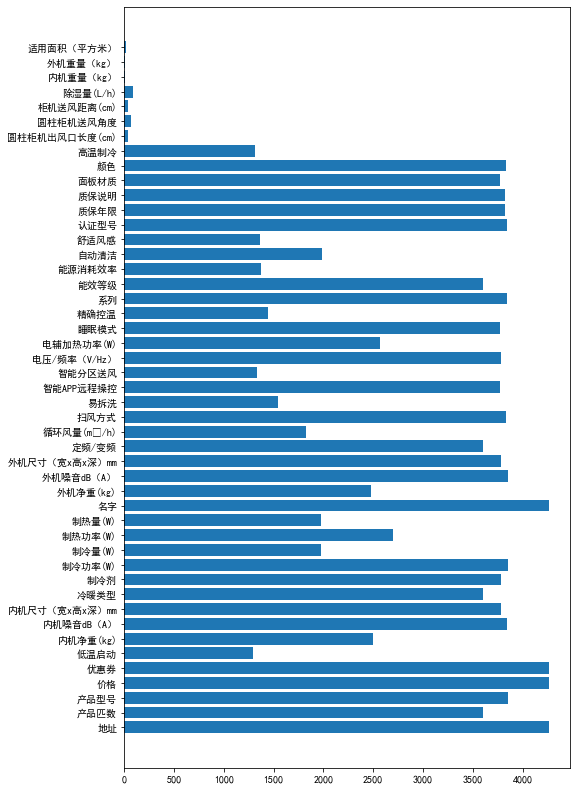

In [4]:
res = mycol.find({},{"_id":0})
key_dict = {}
    
i = 0
for x in res:
    print(i,x[地址])
    i = i + 1
    
    for m in x:
        if(m in key_dict):
            key_dict[m] = key_dict[m] + 1
        else:
            key_dict[m] = 1
print(i, len(key_dict))

label = []
nums = []
for m in key_dict:
    print(m)
    label.append(m)
    nums.append(key_dict[m])
plt.figure(figsize = (8,14))
plt.rcParams['font.sans-serif']=['SimHei']

plt.barh(label,nums)
# plt.xticks(label, label, rotation=-90)
plt.show()

### 统计价格区间

40479.0 79.0 4447
81 81


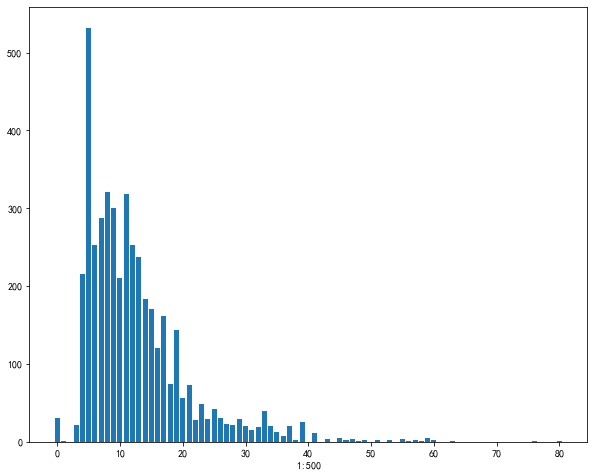

In [23]:
from matplotlib import pyplot as plt 
import numpy as np

res = mycol.find({},{"_id":0}).sort("价格").limit(0)
price_dict = {}
list_data = []
i = 0
max = 2000
min = 2000
for x in res:
    i = i + 1
    if max < x["价格"]:
        max = x["价格"]
    if min > x["价格"]:
        min = x["价格"]
    list_data.append(x["价格"])
    
#     if str(x["价格"]) in price_dict:
#         price_dict[str(x["价格"])] = price_dict[str(x["价格"])] + 1
#     else:
#         price_dict[str(x["价格"])] = 1

# for m in price_dict:
    
#     print(m,'->\t',price_dict[m])
print(max,min,i)

a = np.array(list_data) 
b = [0]*81
for i in a:
    b[int(i/500)] = b[int(i/500)] + 1
x_index = []
for i in range(81):
    x_index.append(i*500)
print(len(b),len(x_index))
plt.figure(figsize = (10,8))
plt.rcParams['font.sans-serif']=['SimHei']
plt.bar(range(81),np.array(b)) 
# plt.title("价格(500)") 
plt.xlabel("1:500")
plt.show()

## 统计制冷剂类型种数

In [13]:
res = mycol.find({},{"_id":0})
zhilengji_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    try:
        if(x["制冷剂"] in zhilengji_dict):
            zhilengji_dict[x["制冷剂"]] = zhilengji_dict[x["制冷剂"]] + 1
        else:
            zhilengji_dict[x["制冷剂"]] = 1
    except:
#         print("无字段")
        pass
print('总计条目：',i,', 总分类数：', len(zhilengji_dict))
for m in zhilengji_dict:
    print(m,'->\t',zhilengji_dict[m])


总计条目： 398 , 总分类数： 2
R32 ->	 374
R410a ->	 4


## 统计制冷功率

398 79
7210 200 398


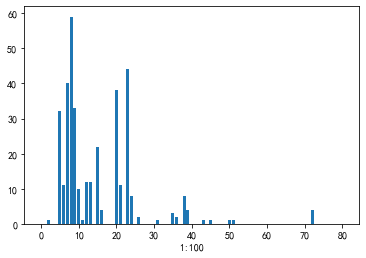

In [9]:
res = mycol.find({},{"_id":0})
zhilengji_dict = {}
max = 2000
min = 2000
i = 0
list_zldata = []
for x in res:
#     print(i,x)
    i = i + 1
    try:
        tmp = re.findall('(\d+)',x["制冷功率(W)"])
#         print(tmp)
        tmp = tmp[0]
        
        if(int(tmp) < 200 or int(tmp) > 8000):
            continue
        
        
        if(tmp in zhilengji_dict):
            zhilengji_dict[tmp] = zhilengji_dict[tmp] + 1
        else:
            zhilengji_dict[tmp] = 1
        if max < int(tmp):
            max = int(tmp)
        if min > int(tmp):
            min = int(tmp)
        list_zldata.append(int(tmp))
    except:
#         print("无字段")
        pass


print(i, len(zhilengji_dict))
# for m in zhilengji_dict:
#     print(m,'->\t',zhilengji_dict[m])

print(max,min,i)

a = np.array(list_zldata) 
b = [0]*81
for i in a:
    b[int(i/100)] = b[int(i/100)] + 1
plt.figure()
plt.bar(range(len(b)),np.array(b)) 
plt.xlabel("1:100")
plt.show()

## 统计制热功率

398 66
4600 710 398


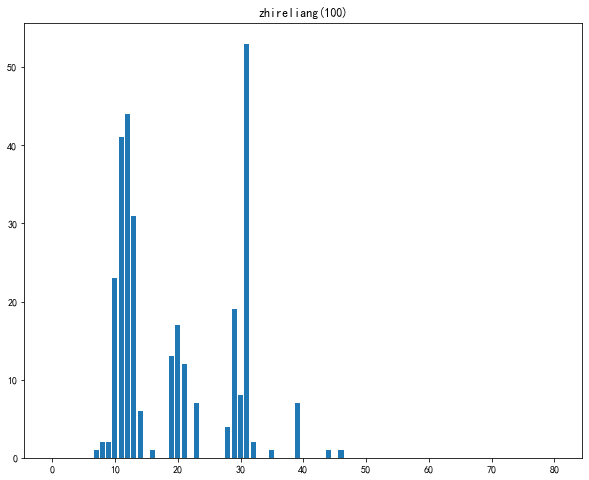

In [10]:
res = mycol.find({},{"_id":0})
zhilengji_dict = {}
max = 2000
min = 2000
i = 0
list_zrdata = []
for x in res:
#     print(i,x)
    i = i + 1
    try:
        tmp = re.findall('(\d+)',x["制热功率(W)"])
#         print(tmp)
        tmp = tmp[0]
        
        if(int(tmp) < 200 or int(tmp) > 8000):
            continue
        
        
        if(tmp in zhilengji_dict):
            zhilengji_dict[tmp] = zhilengji_dict[tmp] + 1
        else:
            zhilengji_dict[tmp] = 1
        if max < int(tmp):
            max = int(tmp)
        if min > int(tmp):
            min = int(tmp)
        list_zrdata.append(int(tmp))
    except:
#         print("无字段")
        pass


print(i, len(zhilengji_dict))
# for m in zhilengji_dict:
#     print(m,'->\t',zhilengji_dict[m])

print(max,min,i)

a = np.array(list_zrdata) 
b = [0]*81
for i in a:
    b[int(i/100)] = b[int(i/100)] + 1
plt.figure(figsize = (10,8))
plt.bar(range(len(b)),np.array(b)) 
plt.title("zhireliang(100)") 
plt.show()

## 统计能效等级

In [51]:
res = mycol.find({},{"_id":0})
zhilengji_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    try:
        tmp = x["能效等级"]
        if(tmp in zhilengji_dict):
            zhilengji_dict[tmp] = zhilengji_dict[tmp] + 1
        else:
            zhilengji_dict[tmp] = 1
    except:
#         print("无字段")
        pass
print(i, len(zhilengji_dict))
for m in zhilengji_dict:
    print(m,'->\t',zhilengji_dict[m])

4443 4
三级能效 ->	 1566
新一级能效 ->	 873
一级能效 ->	 1202
二级能效 ->	 140


## 统计产品匹数

In [46]:
res = mycol.find({},{"_id":0})
zhilengji_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    try:
        tmp = x["产品匹数"]
        if(tmp in zhilengji_dict):
            zhilengji_dict[tmp] = zhilengji_dict[tmp] + 1
        else:
            zhilengji_dict[tmp] = 1
    except:
#         print("无字段")
        pass
print(i, len(zhilengji_dict))
for m in zhilengji_dict:
    print(m,'->\t',zhilengji_dict[m])


4778 12
1.5匹 ->	 888
大1匹 ->	 408
3匹 ->	 968
1匹 ->	 535
2匹 ->	 848
小1.5匹 ->	 57
5匹 ->	 92
小1匹 ->	 24
4匹 ->	 4
2.5匹 ->	 2
正1.5匹 ->	 77
大3匹 ->	 1


## 统计变频定频

In [27]:
res = mycol.find({},{"_id":0})
zhilengji_dict = {}
    
i = 0
for x in res:
#     print(i,x)
    i = i + 1
    try:
        tmp = x["定频/变频"]
        if(tmp in zhilengji_dict):
            zhilengji_dict[tmp] = zhilengji_dict[tmp] + 1
        else:
            zhilengji_dict[tmp] = 1
    except:
#         print("无字段")
        pass
print(i, len(zhilengji_dict))
for m in zhilengji_dict:
    print(m,'->\t',zhilengji_dict[m])

4447 2
变频 ->	 3317
定频 ->	 283


### 更新综合系数

In [48]:
res = mycol.find({})
# for i in res:
#     print(i["名字"])
#     print('\n')
update_zh(res,xishu)

## 基于用户需求的推荐方案

In [58]:

import pandas as pd



# res = mycol.find({"产品匹数":"1.5匹"},
#                  {"_id":0,
#                   "综合系数":1,
#                   "价格":1,
#                   "制冷剂":1,
#                   "制冷功率(W)":1,
#                   "制热功率(W)":1,
#                   "能效等级":1,
#                   "产品匹数":1,
#                   "变频/定频":1,"地址":1}).sort('综合系数',-1)
res = mycol.find({'名字':{ "$regex": "KF-19GW/\(19301、)Aa-3"}},{"_id":0}).sort('价格',1)

def drawpandas(res):
    index = 0
    key_dict = {"综合系数":[],"名字":[],"地址":[],"价格":[],"制冷剂":[],"制冷功率(W)":[],"制热功率(W)":[],"能效等级":[],"产品匹数":[],"变频/定频":[]}
    res_tmp =[]
    for x in res:
        print((x))
        index = index + 1

        check = 0

    #     for i in key_dict:
    #         if i in x:
    #             check = check + 1

    #     if check < len(key_dict):
    #         continue
        for i in key_dict:
            if (i in x) == False:
                x[i] = 'None'
            key_dict[i].append(x[i])
        res_tmp.append(x)
    # # print(key_dict)
    # print (sorted(res_tmp, key = lambda i: (i['综合系数'], i['价格'])) )
    return pd.DataFrame(key_dict)
    # pd.concat([x[:1],x[2:13]],ignore_index=True)
    
drawpandas(res)
# update_zh(res,xishu)

,综合系数,名字,地址,价格,制冷剂,制冷功率(W),制热功率(W),能效等级,产品匹数,变频/定频


## 基于指定元素的推荐结果

In [61]:





# res = mycol.find({'价格':{'$gt':2000,'$lt':3000}},{"_id":0,"综合系数":1,"价格":1,"制冷剂":1,"制冷功率(W)":1,"制热功率(W)":1,"能效等级":1,"产品匹数":1,"变频/定频":1}).sort('综合系数',-1)
tmp_Str = 'KFR23GW(23592)NhAa3'.replace('(','\(').replace(')','\)')
res = mycol.find({"$or":[{'名字':{ "$regex": tmp_Str}},{'产品型号':{"$regex": tmp_Str}}]},{"_id":0}).sort([('地址',-1),('价格',1)])
# index = 0
# key_dict = {"综合系数":[],"地址":[],"价格":[],"制冷剂":[],"制冷功率(W)":[],"制热功率(W)":[],"能效等级":[],"产品匹数":[],"变频/定频":[]}
def upsert(mycol,data):
    if '地址' in data:
        mycol.update_one(
            {'地址':data['地址']},
            {'$set':data},
            upsert=True
        )
    else:
        print("更新数据错误！")

drawpandas(res)
    
#     if len(x) != 8:
#         continue
#     for y in x:
#         print(y)
#         key_dict[y].append(x[y])
# print(index)
# x = pd.DataFrame(key_dict)
# pd.concat([x[:1],x[2:13]],ignore_index=True)
# x

# update_zh(res,xishu)

{'价格': 1969.0, '名字': '品悦定频冷暖小1匹3级能效挂机空调 KFR23GW(23592)NhAa3 清爽白', '地址': 'https://mall.gree.com//goods/product/details?id=1000165228&skuId=1000056409', '品牌': '格力', '挂机/柜机': '挂机', '单冷/冷暖': '冷暖', '产品匹数': '小1匹', '定频/变频': '定频', '能效等级': '三级能效', '适用面积（平方米）': '10以下', '能源消耗效率': '3.25(全年能源消耗效率）', '制冷量(W)': '2350', '制冷功率(W)': '723', '制热量(W)': '2600', '制冷剂': 'R32', '制热功率(W)': '710', '是否电辅加热': '是', '电辅加热功率(W)': '900', '内机噪音dB（A）': '高风挡36', '外机噪音dB（A）': '≤49', '循环风量(m³/h)': '510', '颜色': '清爽白', '电压/频率（V/Hz）': '220V～/50Hz', '内机装箱清单': '室内机*1、遥控器*1、电池*2、说明书*1', '内机尺寸（宽x高x深）mm': '776x268x186', '外机装箱清单': '室外机*1、连接管部件*1', '外机尺寸（宽x高x深）mm ': '776x540x320', '内机质量（kg）': '9.5', '外机质量（kg）': '27.5', '综合系数': 1.80682}
{'地址': 'https://item.jd.com/100018351136.html', '产品匹数': '小1匹', '产品型号': 'KFR23GW(23592)NhAa3', '价格': 1899.0, '优惠券': [], '内机净重(kg)': '9.5kg', '内机噪音dB（A）': '高风挡36', '内机尺寸（宽x高x深）mm': ' 776x268x186', '冷暖类型': '冷暖', '制冷剂': 'R32', '制冷功率(W)': '723', '制热功率(W)': '710', '名字': '格力 GREE 品悦 小1匹 壁挂式定频空调 冷暖空调  KFR23GW

,综合系数,名字,地址,价格,制冷剂,制冷功率(W),制热功率(W),能效等级,产品匹数,变频/定频
0,1.80682,品悦定频冷暖小1匹3级能效挂机空调 KFR23GW(23592)NhAa3 清爽白,https://mall.gree.com//goods/product/details?i...,1969.0,R32,723,710,三级能效,小1匹,None
1,1.82082,格力 GREE 品悦 小1匹 壁挂式定频空调 冷暖空调 KFR23GW(23592)NhAa3,https://item.jd.com/100018351136.html,1899.0,R32,723,710,三级能效,小1匹,None
2,1.58020,格力(GREE)小1匹 品悦 三级能效 定频冷暖 壁挂式 家用空调(清爽白)KFR23GW(...,https://item.jd.com/100005310353.html,2099.0,None,None,None,None,None,None
3,1.72462,格力(GREE)小1匹定频 品悦 以旧换新 壁挂式冷暖空调(清爽白) 线下同款 KFR23G...,https://item.jd.com/100002098027.html,2380.0,R32,723,710,三级能效,小1匹,None


In [53]:
print(len(list(range(10))))

10


In [31]:
lis = [{ "name" : "Taobao", "age" : 100},  
{ "name" : "Runoob", "age" : 7 }, 
{ "name" : "Google", "age" : 100 }, 
{ "name" : "Wiki" , "age" : 200 }] 
  
# 通过 age 升序排序
print ("列表通过 age 升序排序: ")
print (sorted(lis, key = lambda i: i['age']) )
  
print ("\r") 
  
# 先按 age 排序，再按 name 排序
print ("列表通过 age 和 name 排序: ")
print (sorted(lis, key = lambda i: (i['age'], i['name'])) )
  
print ("\r") 
  
# 按 age 降序排序
print ("列表通过 age 降序排序: ")
print (sorted(lis, key = lambda i: (i['age'], i['name']),reverse=True) )

列表通过 age 升序排序: 
[{'name': 'Runoob', 'age': 7}, {'name': 'Taobao', 'age': 100}, {'name': 'Google', 'age': 100}, {'name': 'Wiki', 'age': 200}]

列表通过 age 和 name 排序: 
[{'name': 'Runoob', 'age': 7}, {'name': 'Google', 'age': 100}, {'name': 'Taobao', 'age': 100}, {'name': 'Wiki', 'age': 200}]

列表通过 age 降序排序: 
[{'name': 'Wiki', 'age': 200}, {'name': 'Taobao', 'age': 100}, {'name': 'Google', 'age': 100}, {'name': 'Runoob', 'age': 7}]


In [117]:
res = mycol.find({'价格':3749.0},{"_id":0,
                              "综合系数":1,
                              "地址":1,
                              "价格":1,
                              "制冷剂":1,
                              "制冷功率(W)":1,
                              "制热功率(W)":1,
                              "能效等级":1,
                              "产品匹数":1,
                              "变频/定频":1}).sort('综合系数',-1)
# res = mycol.find({'产品型号':'KFR-26GW/(26564)FNhAa-A1'},{"_id":0}).sort('价格',1)
index = 0
key_dict = {"综合系数":[],"地址":[],"价格":[],"制冷剂":[],"制冷功率(W)":[],"制热功率(W)":[],"能效等级":[],"产品匹数":[],"变频/定频":[]}

drawpandas(res)

# for x in res:
    
#     index = index + 1
    
# #     if index == 10:
# #         break
    
#     print(x)
#     if len(x) != 9:
#         continue
#     for y in x:
# #         print(y)
#         key_dict[y].append(x[y])
# print(len(key_dict["综合系数"]),len(key_dict["地址"]),len(key_dict["价格"]),len(key_dict["制冷剂"]),len(key_dict["制冷功率(W)"]),len(key_dict["制热功率(W)"]),len(key_dict["能效等级"]),len(key_dict["产品匹数"]),len(key_dict["变频/定频"]))

# pd.DataFrame(key_dict)
# pd.concat([x[:1],x[2:13]],ignore_index=True)


# update_zh(res,xishu)

{'价格': 3749.0, '地址': 'https://mall.gree.com//goods/product/details?id=1000025890&skuId=1000042745', '能效等级': '三级能效', '制冷剂': 'R410a', '制热功率(W)': '1430（200-1650）', '综合系数': 2.2751, '产品匹数': '1.5匹', '制冷功率(W)': '1070（100-1420）', '变频/定频': '变频'}
{'价格': 3749.0, '地址': 'https://item.jd.com/66199819161.html', '制冷剂': 'R32', '制冷功率(W)': '875', '制热功率(W)': '1200', '变频/定频': '变频', '能效等级': '一级能效', '产品匹数': '1.5匹', '综合系数': 2.2156000000000002}
{'价格': 3749.0, '地址': 'https://item.jd.com/30162489052.html', '制冷剂': 'R410a', '制冷功率(W)': '880(130-1500)', '制热功率(W)': '1180(180-1630)', '变频/定频': '变频', '能效等级': '二级能效', '产品匹数': '1.5匹', '综合系数': 2.2135000000000002}
{'价格': 3749.0, '地址': 'https://mall.gree.com//goods/product/details?id=1002959256&skuId=1000288184', '能效等级': '二级能效', '制冷剂': 'R410a', '制热功率(W)': '980(85-1600)', '综合系数': 2.0558199999999998, '产品匹数': '大1匹', '制冷功率(W)': '668(75-1730)', '变频/定频': '变频'}
{'价格': 3749.0, '地址': 'https://item.jd.com/100009443111.html', '制冷剂': 'R32', '制冷功率(W)': '600', '制热功率(W)': '1200', '变频/定频': '

,综合系数,地址,价格,制冷剂,制冷功率(W),制热功率(W),能效等级,产品匹数,变频/定频
0,2.27510,https://mall.gree.com//goods/product/details?i...,3749.0,R410a,1070（100-1420）,1430（200-1650）,三级能效,1.5匹,变频
1,2.21560,https://item.jd.com/66199819161.html,3749.0,R32,875,1200,一级能效,1.5匹,变频
2,2.21350,https://item.jd.com/30162489052.html,3749.0,R410a,880(130-1500),1180(180-1630),二级能效,1.5匹,变频
3,2.05582,https://mall.gree.com//goods/product/details?i...,3749.0,R410a,668(75-1730),980(85-1600),二级能效,大1匹,变频
4,1.97710,https://item.jd.com/100009443111.html,3749.0,R32,600,1200,新一级能效,1匹,变频
5,0.92260,https://item.jd.com/66187835634.html,3749.0,R32,765,1360,None,None,None
6,0.62510,https://item.jd.com/10029322613202.html,3749.0,None,None,None,None,None,None
